In [3]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 MB 17.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [33]:
import os
import shutil
import random
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

In [15]:

# Define your dataset path
base_dir = '../../original_dataset'

# Check if the path exists
if os.path.exists(base_dir):
    print(f"The dataset path {base_dir} exists.")
else:
    print(f"The dataset path {base_dir} does not exist.")


The dataset path ../../original_dataset exists.


In [22]:

# Define your target dataset path
target_dir = '../../balanced_dataset'

# Check if the path exists
if os.path.exists(target_dir):
    print(f"The dataset path {target_dir} exists.")
else:
    print(f"The dataset path {target_dir} does not exist.")

The dataset path ../../balanced_dataset exists.


In [19]:
# Define the paths
classes = ['home_office', 'hotel_room', 'church', 'museum', 'supermarket']
target_images_per_class = 700

# Create target directories
os.makedirs(target_dir, exist_ok=True)
for cls in classes:
    os.makedirs(os.path.join(target_dir, cls), exist_ok=True)

# Function to copy images
def copy_images(base_dir, target_dir, classes, num_images):
    for cls in classes:
        class_dir = os.path.join(base_dir, cls)
        target_class_dir = os.path.join(target_dir, cls)
        images = os.listdir(class_dir)
        selected_images = random.sample(images, num_images)
        for img in selected_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(target_class_dir, img))
    print("Images have been copied to the target directory.")

# Copy 700 images from each class
copy_images(base_dir, target_dir, classes, target_images_per_class)

Images have been copied to the target directory.


In [23]:
def show_target_dir_status(target_dir, classes):
    """
    Show the number of images in each class directory within the target directory.

    """
    print(f"Status of target directory: {target_dir}")
    for cls in classes:
        class_dir = os.path.join(target_dir, cls)
        if os.path.exists(class_dir):
            num_images = len(os.listdir(class_dir))
            print(f"Class '{cls}' contains {num_images} images.")
        else:
            print(f"Class directory '{cls}' does not exist.")

# Show the status of the target directory
show_target_dir_status(target_dir, classes)

Status of target directory: ../../balanced_dataset
Class 'home_office' contains 700 images.
Class 'hotel_room' contains 700 images.
Class 'church' contains 700 images.
Class 'museum' contains 700 images.
Class 'supermarket' contains 700 images.


In [24]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = datasets.ImageFolder(target_dir, transform=transform)

# Print the mapping of class indices to class names
print("Class to index mapping:", dataset.class_to_idx)


Class to index mapping: {'church': 0, 'home_office': 1, 'hotel_room': 2, 'museum': 3, 'supermarket': 4}


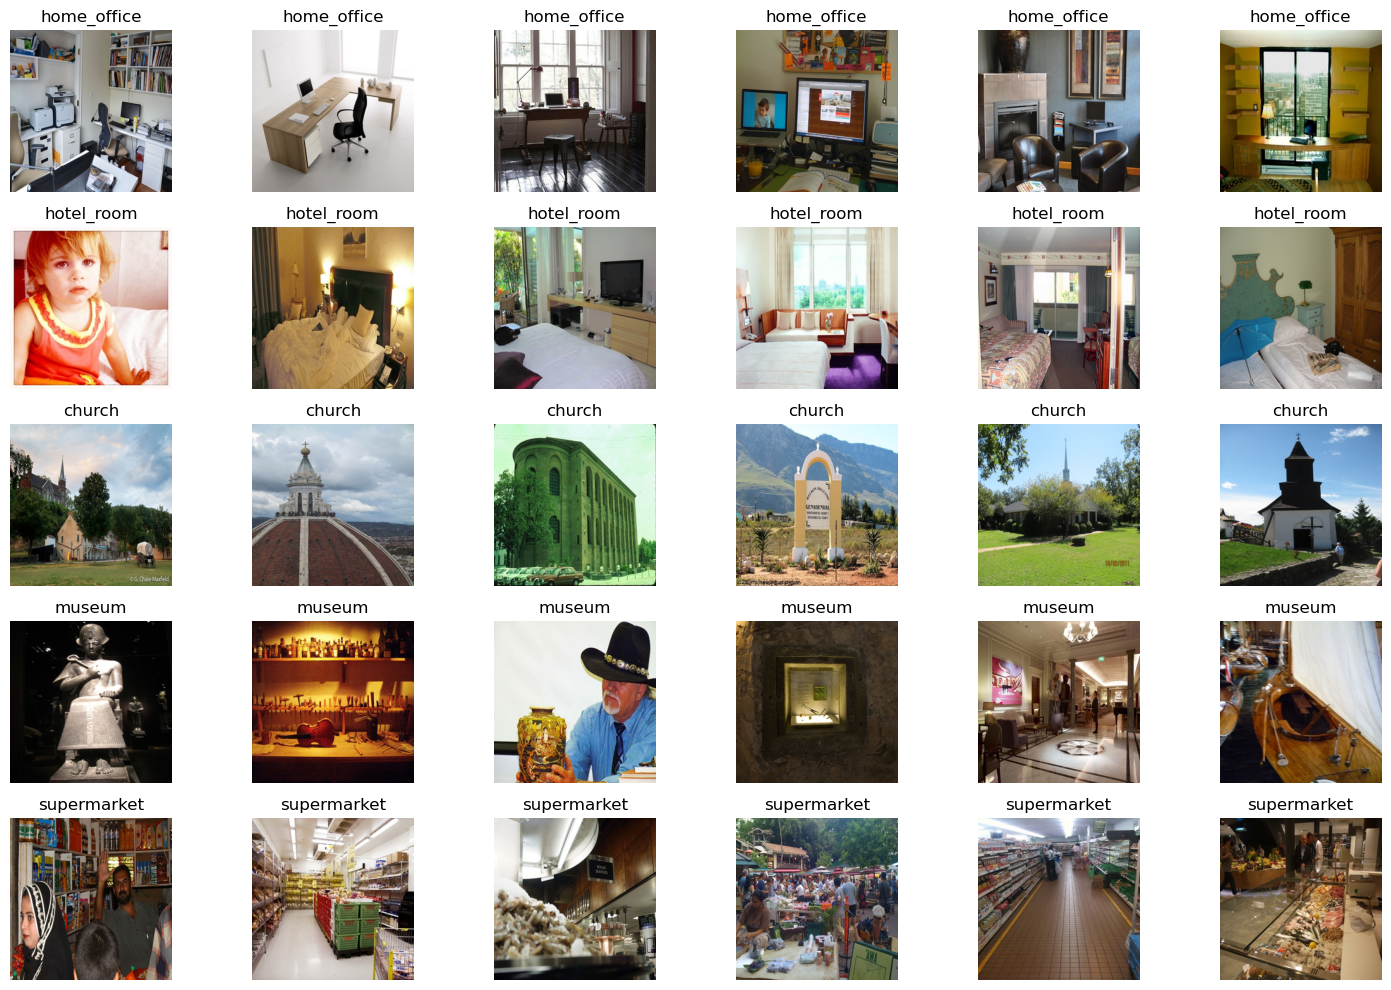

In [34]:
def show_images_with_labels(target_dir, classes, num_images=6):
    """
    Display images with their corresponding labels from the target directory.

    """
    # Create figure and axes
    fig, axes = plt.subplots(len(classes), num_images, figsize=(15, 10))
    
    # Iterate through each class
    for i, cls in enumerate(classes):
        class_dir = os.path.join(target_dir, cls)
        class_images = os.listdir(class_dir)
        selected_images = np.random.choice(class_images, num_images, replace=False)
        
        # Iterate through selected images for the class
        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(class_dir, img_name)
            img = plt.imread(img_path)
            
            # Plot the image
            axes[i, j].imshow(img)
            axes[i, j].set_title(cls)
            axes[i, j].axis('off')
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

show_images_with_labels(target_dir, classes)

In [35]:
def is_image_file(filename):
    """
    Check if a file is an image based on its extension.
    """
    valid_extensions = ('.jpg', '.jpeg', '.png')
    return filename.lower().endswith(valid_extensions)

def preprocess_images(target_dir, classes, image_size=(256, 256)):
    """
    Preprocess images: resize, convert to grayscale (optional), and flatten.

    Parameters:
    - target_dir (str): Path to the target directory containing class folders.
    - classes (list of str): List of class names.
    - image_size (tuple): Desired image size (width, height).

    Returns:
    - X (numpy.ndarray): Flattened image data.
    - y (numpy.ndarray): Corresponding labels.
    """
    X = []
    y = []
    
    for label, cls in enumerate(classes):
        class_dir = os.path.join(target_dir, cls)
        for img_name in os.listdir(class_dir):
            if is_image_file(img_name):
                img_path = os.path.join(class_dir, img_name)
                try:
                    with Image.open(img_path) as img:
                        img = img.resize(image_size)
                        img = img.convert('L')  # Convert to grayscale
                        img_array = np.array(img)
                        # Use HOG for feature extraction
                        features, _ = hog(img_array, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
                        X.append(features)
                        y.append(label)
                except Exception as e:
                    print(f"Error processing file {img_path}: {e}")
    
    X = np.array(X)
    y = np.array(y)
    return X, y


# Preprocess images
X, y = preprocess_images(target_dir, classes)
print("Image data shape:", X.shape)
print("Labels shape:", y.shape)

Image data shape: (3499, 34596)
Labels shape: (3499,)


In [36]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (2799, 34596)
Testing data shape: (700, 34596)


In [41]:
from sklearn.datasets import fetch_california_housing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

In [43]:
# Define the parameter grid to tune the hyperparameters
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize and train the decision tree classifier
dtree_reg = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=dtree_reg, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_dtree_reg = grid_search.best_estimator_ # Get the best estimator from the grid search
y_pred = best_dtree_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
print(f"Test RMSE: {rmse}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
Test RMSE: 1.7439692002522784
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=  59.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=  55.7s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2; total time=  54.6s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10; total time=  54.3s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5; total time=  59.7s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2; total time= 1.1min
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2; total time=  57.1s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10; total time=  56.2s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10; total time=  56.6s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=5; total time

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2; total time= 1.0min
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5; total time=  53.3s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10; total time=  56.6s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2; total time= 1.1min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10; total time=  57.5s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10; total time=  58.8s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5; total time=  57.4s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2; total time=  58.7s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10; total time=  55.6s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10; total time=  56.7s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5; total time=  54.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time= 1.0m

In [45]:
model_grid = RandomForestClassifier(max_depth=20,
                                    min_samples_leaf=2,
                                    min_samples_split=2)
model_grid.fit(X_train, y_train)
y_pred_grid = model_grid.predict(X_test)
print(classification_report(y_pred_grid, y_test))


# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

           0       0.49      0.50      0.50       137
           1       0.56      0.54      0.55       145
           2       0.65      0.64      0.65       142
           3       0.23      0.34      0.27        95
           4       0.66      0.51      0.58       181

    accuracy                           0.52       700
   macro avg       0.52      0.51      0.51       700
weighted avg       0.55      0.52      0.53       700

Accuracy: 0.3057142857142857
Classification Report:
               precision    recall  f1-score   support

 home_office       0.32      0.31      0.32       140
  hotel_room       0.35      0.39      0.37       140
      church       0.37      0.35      0.36       140
      museum       0.19      0.18      0.18       140
 supermarket       0.29      0.29      0.29       140

    accuracy                           0.31       700
   macro avg       0.30      0.31      0.30       700
weighted avg       0.30 